In [904]:
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from umap import UMAP 

from scipy.spatial import distance_matrix

In [905]:
import cv2

In [906]:
PIC_NAME = 'pics/image7.png'

In [907]:
img = cv2.imread(PIC_NAME, 0)

appropriate_scale = 160000

width = img.shape[1]
height = img.shape[0]

base_dim = (height, width)

scaler = width * height / appropriate_scale

scale_percent = int((1 / scaler) * 100) # percent of original size

print('Original Dimensions : ', img.shape)
 
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)

dim = (height, width)

if scale_percent >= 100:
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
else:
    resized = img 

print('Resized Dimensions : ',resized.shape)

Original Dimensions :  (743, 589)
Resized Dimensions :  (743, 589)


In [908]:
def black(img, threshold):
    img[img >= threshold] = 255
    img[img < threshold] = 0
    return img 

def inverse(img):
    return 255 - img

In [909]:
mask = resized.copy()

threshold = 200
_ = black(resized, threshold)

# sns.histplot(mask.flatten())

In [910]:
smoothing_kernel = np.ones((7, 7), np.uint8)
smoothed = black(cv2.morphologyEx(resized, cv2.MORPH_GRADIENT, smoothing_kernel), 230)


In [911]:
smoothing_kernel = np.ones((3, 3), np.uint8)
smoothing_kernel

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8)

In [912]:
connect_kernel = np.array([[1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1]], dtype=np.uint8)

smoothing_3x = np.ones((3, 3), np.uint8)
smoothing_5x = np.ones((5, 5), np.uint8)

In [913]:
smoothed = cv2.morphologyEx(smoothed, cv2.MORPH_CLOSE, connect_kernel)
smoothed = cv2.morphologyEx(smoothed, cv2.MORPH_CLOSE, smoothing_3x)
smoothed = cv2.morphologyEx(smoothed, cv2.MORPH_DILATE, smoothing_5x)
smoothed = cv2.morphologyEx(smoothed, cv2.MORPH_GRADIENT, smoothing_3x)

In [914]:
threshold = 50

mask = smoothed.copy()

black(mask, threshold)

final = inverse(mask)

<AxesSubplot:ylabel='Count'>

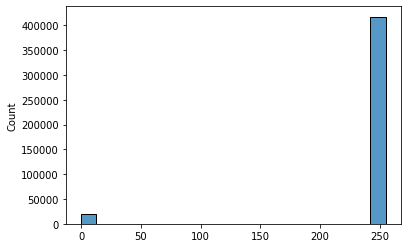

In [915]:
sns.histplot(final.flatten())

In [916]:
dataset = pd.DataFrame(final).stack().reset_index().rename({'level_0': 'y', 'level_1': 'x', 0: 'brightness'}, axis=1)
dataset = dataset[dataset.brightness < 4]

In [917]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20482 entries, 3538 to 434305
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   y           20482 non-null  int64
 1   x           20482 non-null  int64
 2   brightness  20482 non-null  uint8
dtypes: int64(2), uint8(1)
memory usage: 500.0 KB


In [918]:
slice_list = [i for i in range(1, 3)]

In [919]:
epsilon = 2

clustered = dataset.copy()

clustering = DBSCAN(eps=epsilon, min_samples=2).fit(dataset[['y', 'x']])
clustered['cluster'] = clustering.labels_


18

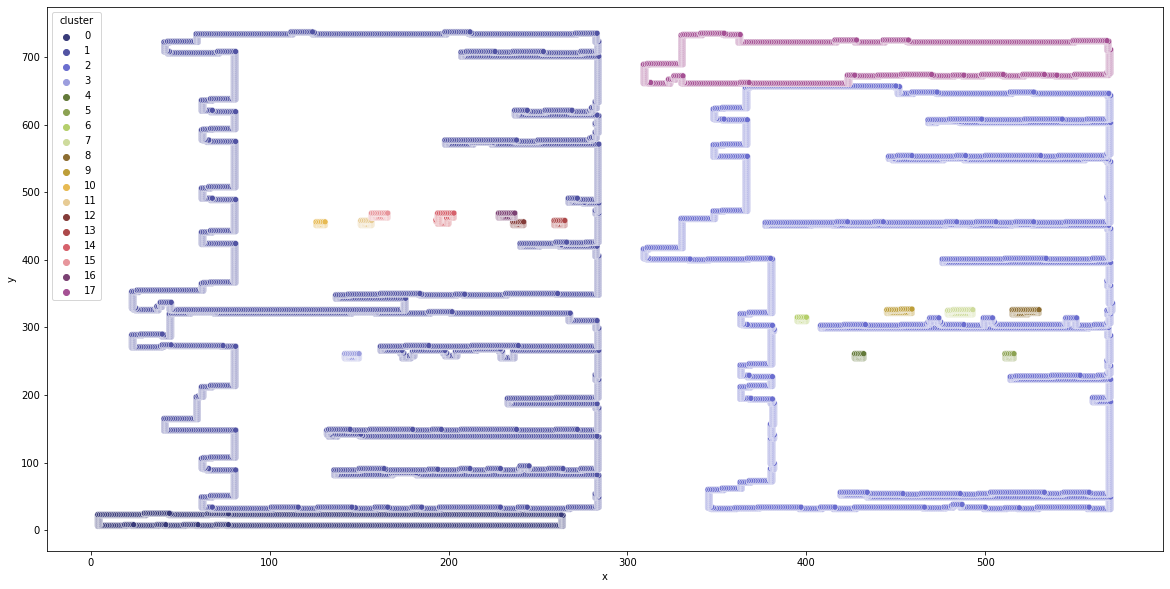

In [920]:
_, axs = plt.subplots(figsize=(20, 10))

sns.scatterplot(data=clustered, x='x', y='y', hue='cluster', ax=axs, palette='tab20b')

clustered.cluster.nunique()

In [921]:
valid_clusters = clustered.groupby('cluster').brightness.value_counts()
valid_clusters = valid_clusters[valid_clusters > 140].unstack().index

In [922]:
filtered_clusters = clustered[clustered.cluster.isin(valid_clusters)]

4

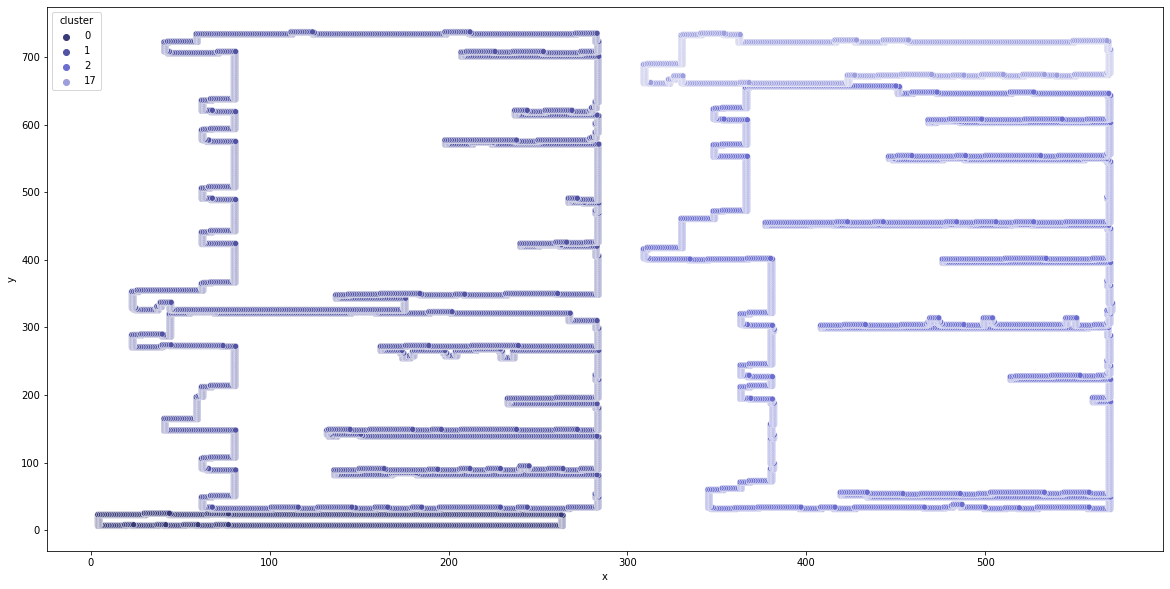

In [923]:
_, axs = plt.subplots(figsize=(20, 10))

sns.scatterplot(data=filtered_clusters, x='x', y='y', hue='cluster', ax=axs, palette='tab20b')

filtered_clusters.cluster.nunique()

In [924]:
borders = filtered_clusters.set_index(['x', 'y']).brightness.unstack().fillna(255).to_numpy()

In [925]:
cv2.imwrite('out/cluster7.png', borders.transpose())

True